In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

print("Environment ready. All core libraries loaded.")


Environment ready. All core libraries loaded.


In [2]:
def sir_simulate(beta, gamma, S0, I0, R0, days=160, dt=0.5):
    steps = int(days / dt) + 1

    t = np.linspace(0, days, steps)
    S = np.zeros(steps)
    I = np.zeros(steps)
    R = np.zeros(steps)

    S[0], I[0], R[0] = S0, I0, R0
    N = S0 + I0 + R0

    for k in range(1, steps):
        dS = -beta * S[k-1] * I[k-1] / N
        dI = beta * S[k-1] * I[k-1] / N - gamma * I[k-1]
        dR = gamma * I[k-1]

        S[k] = S[k-1] + dS * dt
        I[k] = I[k-1] + dI * dt
        R[k] = R[k-1] + dR * dt

        # numerical safety
        S[k] = max(S[k], 0.0)
        I[k] = max(I[k], 0.0)
        R[k] = max(R[k], 0.0)

    peak_I = I.max()
    peak_idx = I.argmax()
    peak_time = t[peak_idx]

    return {
        "t": t,
        "S": S,
        "I": I,
        "R": R,
        "peak_I": peak_I,
        "peak_I_frac": peak_I / N,
        "total_recovered_frac": R[-1] / N,
        "time_to_peak": peak_time
    }


In [3]:
param_bounds = {
    "beta": (0.1, 1.5),        # infection rate
    "gamma": (0.05, 0.5),      # recovery rate
    "I0": (1, 50),             # initial infected
    "population": (500, 5000), # population size
    "days": (80, 200)          # simulation horizon
}

param_bounds


{'beta': (0.1, 1.5),
 'gamma': (0.05, 0.5),
 'I0': (1, 50),
 'population': (500, 5000),
 'days': (80, 200)}

In [4]:
rng = np.random.default_rng(42)
n_simulations = 1000

records = []

for i in range(n_simulations):
    beta = rng.uniform(*param_bounds["beta"])
    gamma = rng.uniform(*param_bounds["gamma"])
    N = int(rng.integers(*param_bounds["population"]))
    I0 = int(rng.integers(*param_bounds["I0"]))
    days = int(rng.integers(*param_bounds["days"]))

    S0 = N - I0
    R0 = 0

    sim = sir_simulate(beta, gamma, S0, I0, R0, days=days)

    record = {
        "beta": beta,
        "gamma": gamma,
        "N": N,
        "I0": I0,
        "days": days,
        "peak_I_frac": sim["peak_I_frac"],
        "time_to_peak": sim["time_to_peak"],
        "total_recovered_frac": sim["total_recovered_frac"],
        "R0_basic": beta / gamma,
        "beta_minus_gamma": beta - gamma,
        "beta_over_gamma": beta / gamma
    }

    # label definition
    record["severe_outbreak"] = int(sim["peak_I_frac"] > 0.10)

    records.append(record)

df = pd.DataFrame(records)
df.head()


,beta,gamma,N,I0,days,peak_I_frac,time_to_peak,total_recovered_frac,R0_basic,beta_minus_gamma,beta_over_gamma,severe_outbreak
0,1.183538,0.247495,2448,43,90,0.502432,6.5,0.995044,4.782064,0.936043,4.782064,1
1,0.231848,0.489030,3638,37,171,0.010170,0.0,0.019092,0.474098,-0.257182,0.474098,0
2,1.200490,0.107651,4278,23,140,0.730152,8.0,0.999997,11.151671,1.092839,11.151671,1
3,1.397471,0.339739,2168,20,178,0.453188,6.5,0.989713,4.113363,1.057732,4.113363,1
4,0.720780,0.152257,914,28,186,0.487647,9.0,0.993422,4.733956,0.568522,4.733956,1


In [5]:
print(df.shape)
df.describe()


(1000, 12)


,beta,gamma,N,I0,days,peak_I_frac,time_to_peak,total_recovered_frac,R0_basic,beta_minus_gamma,beta_over_gamma,severe_outbreak
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.802655,0.272732,2697.627000,25.609000,137.064000,0.328675,12.154500,0.757651,4.162113,0.529923,4.162113,0.729000
std,0.411012,0.129777,1314.305135,14.273186,34.751253,0.247077,13.923191,0.341054,3.970541,0.438205,3.970541,0.444699
min,0.101154,0.050447,505.000000,1.000000,80.000000,0.000221,0.000000,0.000339,0.245700,-0.361046,0.245700,0.000000
25%,0.446888,0.158282,1572.000000,13.000000,106.750000,0.084399,6.000000,0.630769,1.564995,0.155081,1.564995,0.000000
50%,0.796938,0.270592,2588.000000,26.000000,136.000000,0.314691,8.500000,0.946104,2.893987,0.535194,2.893987,1.000000
75%,1.156738,0.385866,3923.250000,38.000000,168.000000,0.524413,14.000000,0.996074,5.148407,0.903634,5.148407,1.000000
max,1.498360,0.499894,4997.000000,49.000000,199.000000,0.881758,146.000000,1.000000,28.733319,1.436681,28.733319,1.000000


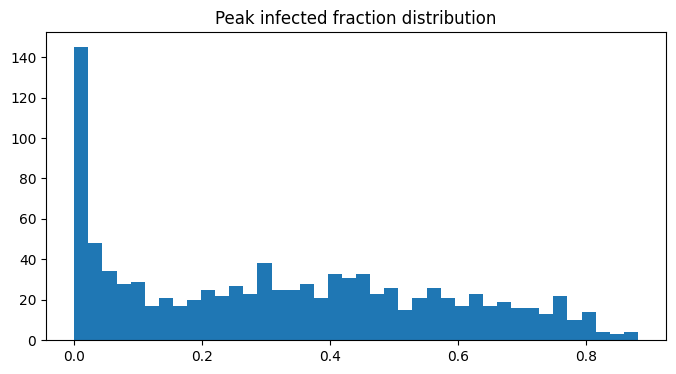

In [6]:
plt.figure(figsize=(8,4))
plt.hist(df["peak_I_frac"], bins=40)
plt.title("Peak infected fraction distribution")
plt.show()


In [7]:
features = [
    "beta", "gamma", "N", "I0", "days",
    "R0_basic", "beta_minus_gamma", "beta_over_gamma"
]

X = df[features]
y = df["severe_outbreak"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
models = {
    "LogisticRegression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "SVC": make_pipeline(StandardScaler(), SVC(probability=True, max_iter=1000)),
    "KNN": make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "MLP": make_pipeline(StandardScaler(), MLPClassifier(max_iter=500, random_state=42))
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    try:
        probs = model.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, probs)
    except:
        auc = np.nan

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, zero_division=0),
        "Recall": recall_score(y_test, preds, zero_division=0),
        "F1": f1_score(y_test, preds, zero_division=0),
        "ROC_AUC": auc
    })

results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
5,DecisionTree,1.000,1.000000,1.000000,1.000000,1.000000
1,RandomForest,0.995,0.993197,1.000000,0.996587,0.999937
2,GradientBoosting,0.995,1.000000,0.993151,0.996564,1.000000
0,LogisticRegression,0.985,1.000000,0.979452,0.989619,1.000000
6,MLP,0.985,1.000000,0.979452,0.989619,0.999239
3,SVC,0.980,1.000000,0.972603,0.986111,0.998351
4,KNN,0.965,0.992908,0.958904,0.975610,0.991819


In [9]:
best_model = results_df.iloc[0]
best_model


,5
Model,DecisionTree
Accuracy,1.0
Precision,1.0
Recall,1.0
F1,1.0
ROC_AUC,1.0


In [13]:
# CSV files
df.to_csv("simulations_1000.csv", index=False)
results_df.to_csv("model_comparison.csv", index=False)



In [14]:
from google.colab import files

files.download("simulations_1000.csv")
files.download("model_comparison.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

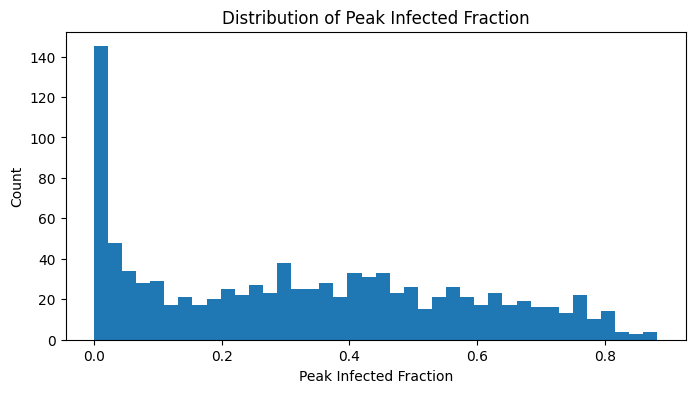

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))        # 1. Create figure
plt.hist(df["peak_I_frac"], bins=40)
plt.title("Distribution of Peak Infected Fraction")
plt.xlabel("Peak Infected Fraction")
plt.ylabel("Count")

plt.savefig(
    "peak_distribution.png",
    dpi=300,
    bbox_inches="tight"
)                                  # 2. Save FIRST

plt.show()                          # 3. Then show
plt.close()                         # 4. Close figure



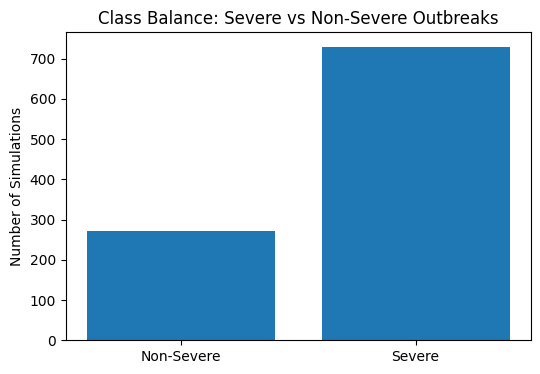

In [16]:
plt.figure(figsize=(6, 4))          # 1. Create figure

counts = df["severe_outbreak"].value_counts().sort_index()
labels = ["Non-Severe", "Severe"]

plt.bar(labels, counts.values)
plt.title("Class Balance: Severe vs Non-Severe Outbreaks")
plt.ylabel("Number of Simulations")

plt.savefig(
    "class_balance.png",
    dpi=300,
    bbox_inches="tight"
)                                  # Save FIRST

plt.show()
plt.close()


In [17]:
from google.colab import files
files.download("peak_distribution.png")
files.download("class_balance.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>